In [1]:
from MonteCarlo import GeometricBrownianMotion, Option, RandomNumberGenerator
from Pricing import CallPrice, PutPrice, DigitalCallPrice, DigitalPutPrice, ForwardPrice
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Parameters
r = 0.3
d = 0.1
T = 10
vol = 0.2
N_T = 10000
S_0 = 1
seed = 1
n_final_values = 100000

In [3]:
#initialise GBM class with parameters
gbm = GeometricBrownianMotion(r=r, d=d, T = T, vol = vol, N_T= N_T, S_0 = S_0, seed = seed)
#Simulate n final stock prices using stochastic solution to GBM equation
final_values = gbm.final_values(n=n_final_values)

In [11]:
#Initialisng an option object, and using monte carlo pricer with simulated stock prices.
K = 4
option = CallOption(K = K)
mc_price = gbm.monte_carlo_price(final_values=final_values, option = option)
exact_price = CallPrice(r=r, d=d, T = T, vol = vol,K=K, S = S_0)
print(f'Exact price = {exact_price}, Estimated price = {mc_price}')

Exact price = 1.7696089579814334, Estimated price = 1.7478645936436676


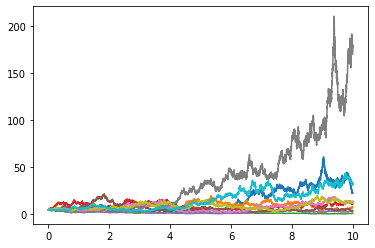

In [12]:
gbm.plot_paths(n=10, method='euler')

C:\Users\rumai\AppData\Local\Temp\ipykernel_9916\2148140753.py:22: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.arange(N_conv), np.log10(errors))


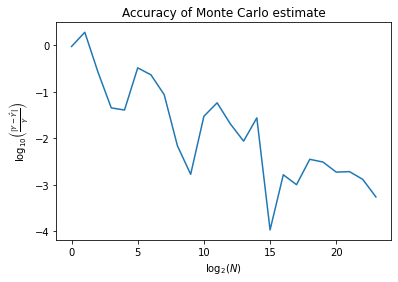

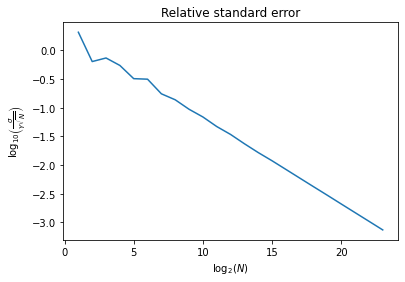

Convergence of standard error to 1% of true value for N = 65536
Convergence of standard error to 0.1% of true value for N = 8388608


In [10]:
#Code to study convergence of Monte Carlo
N_conv = 24 # max number of paths simulated in convergence test = 2^N_conv
K = 4
option = Option(K = K, type='put')
def get_convergence(N_conv, option):
    gbm_test = GeometricBrownianMotion(r=r, d=d, T = T, vol = vol, N_T= N_T, S_0 = S_0, seed = None)
    diff = np.zeros(N_conv)
    errors = np.zeros(N_conv)
    for i in range(N_conv):
        final_values = gbm_test.final_values(n=2**i)
        mc_price, _, standard_error = gbm_test.monte_carlo_price(final_values=final_values, option = option, return_variance=True)
        exact_price = PutPrice(r=r, d=d, T = T, vol = vol,K=K, S = S_0)
        diff[i] = np.abs(mc_price - exact_price)/exact_price
        errors[i] = standard_error/exact_price
    plt.figure()
    plt.plot(np.arange(N_conv), np.log10(diff))
    plt.xlabel(r'$\log _2 (N)$')
    plt.ylabel(r'$\log_{10} \left( \frac{|Y - \hat{Y}|}{Y} \right)$')
    plt.title('Accuracy of Monte Carlo estimate')

    plt.figure()
    plt.plot(np.arange(N_conv), np.log10(errors))
    plt.xlabel(r'$\log _2 (N)$')
    plt.ylabel(r'$\log_{10} \left( \frac{\sigma}{Y\sqrt{N}} \right)$')
    plt.title('Relative standard error')

    plt.show() 

    i = 4
    while errors[i] > 0.01 and i<len(errors):
        i+=1

    print(f'Convergence of standard error to 1% of true value for N = {2**i}')

    i = 4
    while errors[i] > 0.001 and i<len(errors):
        i+=1
    print(f'Convergence of standard error to 0.1% of true value for N = {2**i}')

get_convergence(N_conv, option)


We check the convergence of our Monte Carlo pricer. Let $N$ be the number of simulated stocks used to estimate the price, $Y$ the actual price, $\hat{Y}$ our estimate, and $\sigma^2$ the variance of . We plot the relative difference between our estimate and the actual price against $\log_2 N$, and find convergence to $0.1 \%$ of the true value when $N \sim 10^5$. On analysis of standard errors, we find a relative standard error of less than $0.1 \%$ for $N \sim 10^6$, while an agreement up to $1 \%$ is reached by $N \sim 10^4$. Therefore it will be appropriate to use $N = 10^6$ for our purposes, balancing accuracy and computational cost.

In [25]:
#validating Monte Carlo pricer against analytical solutions for various derivatives. We generate random parameter values and check relative errors of 
#Monte Carlo estiamtes accross different derivative types. The code returns any instances where relative error exceeds 5%
tol = 10**-3 #absolute difference tolerance to account for exact prices near 0
N_r = 100 #number of random parameter value combinations tested
types = ['call',
'put',
'dcall',
'dput']
#'forward']
total_tests = 0
failed_tests = 0
rng = RandomNumberGenerator() #generator for standard uniform variable
for _ in range(N_r):
    r, d, T, vol, K, S_0 = rng.generate()[0], rng.generate()[0], rng.generate()[0]*20,rng.generate()[0], rng.generate()[0]*10, rng.generate()[0]*10 #initialise random parameters
    exact_prices = {
        'call': CallPrice(r=r, d=d, T = T, vol = vol,K=K, S = S_0),
        'put': PutPrice(r=r, d=d, T = T, vol = vol,K=K, S = S_0),
        'dcall':DigitalCallPrice(r=r, d=d, T = T, vol = vol,K=K, S = S_0),
        'dput':DigitalPutPrice(r=r, d=d, T = T, vol = vol,K=K, S = S_0),
        'forward':ForwardPrice(r=r, d=d, T = T,K=K, S = S_0)
    }
    gbm_test = GeometricBrownianMotion(r=r, d=d, T = T, vol = vol, S_0 = S_0, seed = None)
    for option_type in types:
        option = Option(K = K, option_type=option_type)
        final_values = gbm_test.final_values(n=1000000)
        mc_price = gbm_test.monte_carlo_price(final_values=final_values, option = option)
        exact_price = exact_prices[option_type]
        if abs(mc_price - exact_price) < tol:
            relative_error = abs(mc_price - exact_price)
        else:
            relative_error = abs(mc_price - exact_price)/exact_price
        total_tests += 1
        if abs(relative_error) > 0.01:
            failed_tests +=1
            print(mc_price, exact_price, relative_error, option_type)
print(f'{failed_tests} of {total_tests} gave relative error > 1%')


0.07187824550262906 0.07449159192817181 0.035082434915106445 call
0.15374936831164218 0.15657889491713248 0.01807093227339348 call
0.03808272803989441 0.04010563561269877 0.05043948417473373 call
0.14859317442124859 0.1518077550302612 0.021175338561404994 call
0.5711252416382573 0.5811354061019305 0.01722518428332936 call
0.3624398939011078 0.37462019440047967 0.032513731724645806 call
0.48574903394179025 0.5979682014911532 0.18766744999068843 call
0.3557365956989144 0.34649619560790984 0.02666811413266101 call
0.16301016188313117 0.19116571595064696 0.14728349132845917 call
0.19354982457487388 0.21778577395785623 0.11128343666594243 call
1.3833510360721741 1.4445708930956687 0.04237926799999573 call
11 of 400 gave relative error > 10%


On running the above tests, we find agreement between the Monte Carlo prices and analytic solutions. We find that more than $95\%$ of simulated prices are within $1\%$ of the true value. We can therefore be confident in our implementations of both the Monte Carlo pricer and analytic prices.